<a href="https://colab.research.google.com/github/rnjsdn12332/speech2face/blob/main/speech2face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytube moviepy youtube_dl #pytube 영상 저장 , moviepy : 비디오처리 youtube_dl : 유튜브 다운

     |████████████████████████████████| 61kB 4.2MB/s 
     |████████████████████████████████| 1.9MB 12.3MB/s 


In [ ]:
!pip install opencv-python dlib torchvision #dlib : 얼굴 검출

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install face_recognition
import cv2
import face_recognition
import torch 
from torch import nn

  Using cached https://files.pythonhosted.org/packages/1e/95/f6c9330f54ab07bfa032bf3715c12455a381083125d8880c43cbe76bb3d0/face_recognition-1.3.0-py2.py3-none-any.whl
     |████████████████████████████████| 100.2MB 42kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566184 sha256=23057d932e41395b1a608d3d55131c9f26a658763773e47c9e0722f98282f5be
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision import transforms,models
import pickle
import pandas as pd
import youtube_dl
import moviepy.editor as mp
import os
import torch.nn as nn
import torch.nn.functional as F
import librosa
import dlib

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3506176/45929032 bytes (7.6%)6782976/45929032 bytes (14.8%)10641408/45929032 bytes (23.2%)14606336/45929032 bytes (31.8%)18317312/45929032 bytes (39.9%)22290432/45929032 bytes (48.5%)26132480/45929032 bytes (56.9%)30162944/45929032 bytes (65.7%)34037760/45929032 bytes (74.1%)37928960/45929032 bytes (82.6%)41697280/45929032 bytes (90.8%)45506560/45929032 bytes (99.1%)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
!ls

In [ ]:
! wget http://dlib.net/files/mmod_human_face_detector.dat.bz2

--2021-07-18 06:10:25--  http://dlib.net/files/mmod_human_face_detector.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694709 (678K)
Saving to: ‘mmod_human_face_detector.dat.bz2’

mmod_human_face_det 100%[===================>] 678.43K  --.-KB/s    in 0.04s   

2021-07-18 06:10:25 (18.7 MB/s) - ‘mmod_human_face_detector.dat.bz2’ saved [694709/694709]



In [ ]:
!bzip2 -dk mmod_human_face_detector.dat.bz2

In [ ]:
%rm mmod_human_face_detector.dat.bz2

In [ ]:
cnn_face_detector = dlib.cnn_face_detection_model_v1("/content/mmod_human_face_detector.dat")
hog_face_detector = dlib.get_frontal_face_detector()

In [ ]:
# 얼굴 추출 함수
def extract_face(frame): 
  
    faces_cnn = cnn_face_detector(frame, 2)

    x,y,w,h = 0,0,0,0
    for face in faces_cnn:
        
        x = face.rect.left()
        y = face.rect.top()
        w = face.rect.right() - x
        h = face.rect.bottom() - y

    if (x<=0 or y<=0 or w<=0 or h<=0):
        return None

    frame = frame[y:y + h,x:x+w]
    return frame

In [ ]:
# vgg 모델 생성
def create_vgg_model() : 

    PATH = "http://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/vgg_face_dag.pth"
    PATH2 = "http://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/vgg_m_face_bn_dag.pth"
    model = models.vgg16(pretrained=PATH)
    layers = list(model.classifier.children())
    #print(layers)
    layers.pop()
    layers.pop()
    new_classifier = torch.nn.Sequential(*layers)
    model.classifier = new_classifier

    return model

In [ ]:
vgg_model = create_vgg_model()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
vgg_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for param in vgg_model.parameters():
    param.requires_grad = False

In [ ]:
vgg_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

얼굴 이미지 쉐이프 조정

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

배치에 사용할 이미지 특징 추출

In [ ]:
#이미지 특징 검출

def extract_image_features(image_path_list):


    face_batch = []

    for image_path in image_path_list: 
        frame = Image.open(image_path)
    
        frame_arr = np.asarray(frame) 
        face_arr = extract_face(frame_arr)

    if(face_arr is None):
        return None

    face = Image.fromarray(np.uint8(face_arr)).convert('RGB') #넘파이 배열을 PIL 이미지로 변환
    
    face_tensor = transform(face) #이미지 조정(텐서 + 리사이즈)
   
    face_batch.append(face_tensor.numpy()) #다시 넘파이로 변환한 값 리스트에 추가
  

    face_batch = torch.tensor(face_batch).to(device)
   
    face_features = vgg_model(face_batch)

    return face_features

In [ ]:
#텐서로 변환한 페이스 배치 리턴
def extract_faces_features(image_path_list):
    face_batch = []

    for image_path in image_path_list: 

        frame = Image.open(image_path)
  
        frame_arr = np.asarray(frame)
        face_arr = extract_face(frame_arr)
    if(face_arr is None):
        return None

    face = Image.fromarray(np.uint8(face_arr)).convert('RGB')
    #face = Image.fromarray(face_arr)
    face_tensor = transform(face)
    #print(face_tensor.shape)
    face_batch.append(face_tensor.numpy())
    #print(face_tensor.device)

    face_batch = torch.tensor(face_batch).to(device)
    return face_batch

In [ ]:

def get_spectrogram(audio_path):

  wav_file , sr = librosa.load(audio_path,sr = 16000, duration = 6.0 ,mono = True) #wav_file은 파형의 amplitude, sr은 sampling rate
  stft = librosa.core.stft(wav_file, n_fft = 512, hop_length = int(np.ceil(0.01 * sr)),win_length = int(np.ceil(0.025 * sr)) , window='hann', center=True,pad_mode='reflect')
  #stft는 스펙트로그램

  if stft.shape[1] < 598:
    stft = np.concatenate((stft,stft[:,0:598 - stft.shape[1]]),axis = 1)
  else:
    stft = stft[:,:598]

  real = np.sign(stft.real) * ( np.abs(stft.real) ** 0.3 )
  imag = np.sign(stft.imag) * ( np.abs(stft.imag) ** 0.3 )

  stft = np.stack((real,imag),axis=-1)
  
  return stft

In [ ]:
class AudioEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(2, 32, kernel_size=(4,4) , stride=(1,1) )
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=(4,4) , stride=(1,1) )
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=(4,4) , stride=(1,1) )
        self.bn3 = nn.BatchNorm2d(64)

        self.pool1 = nn.MaxPool2d((2,1),stride=(2,1))

        self.conv4 = nn.Conv2d(64, 64, kernel_size=(4,4) , stride=(1,1) )
        self.bn4 = nn.BatchNorm2d(64)

        self.pool2 = nn.MaxPool2d((2,1),stride=(2,1))

        self.conv5 = nn.Conv2d(64, 64, kernel_size=(4,4) , stride=(1,1) )
        self.bn5 = nn.BatchNorm2d(64)

        self.pool3 = nn.MaxPool2d((2,1),stride=(2,1))

        self.conv6 = nn.Conv2d(64, 128, kernel_size=(4,4) , stride=(1,1) )
        self.bn6 = nn.BatchNorm2d(128)

        self.pool4 = nn.MaxPool2d((2,1),stride=(2,1))

        self.conv7 = nn.Conv2d(128, 256, kernel_size=(4,4) , stride=(1,1) )
        self.bn7 = nn.BatchNorm2d(256)

        self.conv8 = nn.Conv2d(256, 256, kernel_size=(4,4) , stride=(2,2) )
        self.bn8 = nn.BatchNorm2d(256)

        self.conv9 = nn.Conv2d(256, 256, kernel_size=(4,4) , stride=(2,2) )

        self.avg1  = nn.AvgPool2d((1,1),1)
        self.bn9 = nn.BatchNorm2d(256)

        self.flatten = nn.Flatten()

        #self.fc1 = nn.Linear(419328,256)
        self.fc1 = nn.Linear(87552,256)
        self.fc2 = nn.Linear(256,1024)
        self.fc3 = nn.Linear(1024,4096)
        self.fc4 = nn.Linear(4096,4096)

    def forward(self,x):

        x = self.bn1(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.bn2(F.relu(self.conv2(x)))
        #print(x.shape)
        x = self.bn3(F.relu(self.conv3(x)))
        #print(x.shape)

        x = self.pool1(x)
        #print(x.shape)

        x = self.bn4(F.relu(self.conv4(x)))
        #print(x.shape)
        x = self.pool2(x)
        #print(x.shape)

        x = self.bn5(F.relu(self.conv5(x)))
        #print(x.shape)
        x = self.pool3(x)
        #print(x.shape)

        x = self.bn6(F.relu(self.conv6(x)))
        #print(x.shape)
        x = self.pool4(x)
        #print(x.shape)

        x = self.bn7(F.relu(self.conv7(x)))
        #print(x.shape)
        x = self.bn8(F.relu(self.conv8(x)))
        #print(x.shape)
        x = self.conv9(x)
        #print(x.shape)

        x = self.bn9(F.relu(self.avg1(x)))
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        x = F.relu(self.fc3(x))
        #print(x.shape)
        x = self.fc4(x)
        #print(x.shape)

        return x

In [ ]:
audio_encoder = AudioEncoder()
audio_encoder.to(device)

AudioEncoder(
  (conv1): Conv2d(2, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=(2, 1), stri

In [ ]:
for p in audio_encoder.parameters():

  if p.requires_grad:
    print(p.numel())

1024
32
32
32
16384
32
32
32
32768
64
64
64
65536
64
64
64
65536
64
64
64
131072
128
128
128
524288
256
256
256
1048576
256
256
256
1048576
256
256
256
22413312
256
262144
1024
4194304
4096
16777216
4096


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(audio_encoder)

46593664

In [ ]:
root_dir_path = '/content'
path = os.path.join(root_dir_path,'images')
os.mkdir(path)
path = os.path.join(root_dir_path,'videos')
os.mkdir(path)
path = os.path.join(root_dir_path,'audios')
os.mkdir(path)

In [ ]:
root_dir_path = '/content'

In [ ]:

def extract_frame(id,start,end):

  video_path = root_dir_path + '/videos/' + id + '.mp4'
  image_path = root_dir_path + '/images/' + id + '.jpg'

  clip = mp.VideoFileClip(video_path)
  dur = clip.duration
  end = min(end,dur)
  if(start>=end):
    return

  clip = clip.subclip(start, end)
  
  clip.save_frame(image_path, t = 1)

In [ ]:

def extract_audio(id,start,end):

  video_path = root_dir_path + '/videos/' + id + '.mp4'
  audio_path = root_dir_path + '/audios/' + id + '.wav'

  clip = mp.VideoFileClip(video_path)
  dur = clip.duration
  end = min(end,dur)
  if (start >= end):
    print('start more than video total length')
    return None
    
  clip = clip.subclip(start, end)
  
  clip.audio.write_audiofile(audio_path)

  stft = get_spectrogram(audio_path)

  return stft

In [ ]:
ydl_opts = {'format': 'best' , 'outtmpl':'/content/videos/%(id)s.mp4'}
ydl = youtube_dl.YoutubeDL(ydl_opts)

In [ ]:
def download_video(id,start,end):

  video_link="https://www.youtube.com/watch?v=" + id 
  #print(video_link)
  try: 
      ydl.download([video_link.strip()])
  except: 
    print('error in downloading videos')
    return

  stft = extract_audio(id,start,end)
  if (stft is None):
    print('stft is none')
    return None
  extract_frame(id,start,end)
  video_path = '/content/videos/' + id + '.mp4'
  %rm $video_path
  return stft

데이터셋


In [ ]:
file = pd.read_csv('/content/drive/MyDrive/avspeech_csv/avspeech_test.csv',names=['id','start','end','X','Y'])

In [ ]:
def preprocess_data(batch_no , batch_size , reference = False):


  spectrogram_dict = {}
  image_path_list = []

  for i in range(batch_no*batch_size , (batch_no+1)*batch_size):
    id , start , end , X ,Y = file.iloc[i]

    spectrogram = download_video(id,start,end)

    if (spectrogram is None):
            continue

    if (type(spectrogram) == np.ndarray):
      spectrogram_dict[id] = spectrogram

      path = '/content/images/' + id + '.jpg'
      image_path_list.append(path)
    
  image_features = extract_image_features(image_path_list)
    #return
  if (image_features is None or image_features.shape[0] != len(spectrogram_dict.keys())):
      return

  if (reference):
      image_feat_file = '/content/reference/vgg_image_features_' + str(batch_no)
  else:  
      image_feat_file = '/content/vgg_image_features_' + str(batch_no)

  torch.save(image_features,image_feat_file)
  if (reference):
      spec_pickle_file = '/content/reference/spectrograms_' + str(batch_no) + '.pk' 
  else:
      spec_pickle_file = '/content/spectrograms_' + str(batch_no) + '.pk' 

  f = open(spec_pickle_file, 'wb')
  pickle.dump(spectrogram_dict, f)
  f.close()

  if (reference) :
    for image_path in image_path_list:
      image_id = image_path.split('/content/images/')[1]
      drive_path = '/content/reference/' + image_id

      %mv $image_path $drive_path

In [ ]:
train_size = 10000
batch_size = 10
n_batches = int(train_size / batch_size)

for i in range(1002,1100):

  preprocess_data(i,batch_size,True)
  #break

[download]  41.5% of 100.58MiB at 40.52KiB/s ETA 24:46error in downloading videos
[youtube] B-aIq_36MAQ: Downloading webpage
[download] Destination: /content/videos/B-aIq_36MAQ.mp4
[download] 100% of 53.35MiB in 00:01
[MoviePy] Writing audio in /content/audios/B-aIq_36MAQ.wav


100%|██████████| 322/322 [00:00<00:00, 2354.47it/s]

[MoviePy] Done.


[youtube] M3A9SNadRcY: Downloading webpage
[download] Destination: /content/videos/M3A9SNadRcY.mp4
[download]  24.3% of 192.88MiB at  2.16MiB/s ETA 01:07error in downloading videos
[youtube] lNGtzaocsAA: Downloading webpage
[download] Destination: /content/videos/lNGtzaocsAA.mp4
[download] 100% of 167.41MiB in 00:06
[MoviePy] Writing audio in /content/audios/lNGtzaocsAA.wav


100%|██████████| 67/67 [00:00<00:00, 505.91it/s]

[MoviePy] Done.


[youtube] IrXRtlkG6A4: Downloading webpage
[download] Destination: /content/videos/IrXRtlkG6A4.mp4
[download] 100% of 78.65MiB in 00:05
[MoviePy] Writing audio in /content/audios/IrXRtlkG6A4.wav


100%|██████████| 67/67 [00:00<00:00, 1132.36it/s]

[MoviePy] Done.


[youtube] -nZq0E39E34: Downloading webpage
[youtube] -nZq0E39E34: Downloading MPD manifest
[download] Destination: /content/videos/-nZq0E39E34.mp4
[download]   6.0% of 55.43MiB at 59.28KiB/s ETA 14:59error in downloading videos
[youtube] jyDpmNK1C3o: Downloading webpage
[download] Destination: /content/videos/jyDpmNK1C3o.mp4
[download] 100% of 37.35MiB in 00:03
[MoviePy] Writing audio in /content/audios/jyDpmNK1C3o.wav


100%|██████████| 78/78 [00:00<00:00, 573.10it/s]

[MoviePy] Done.


[youtube] lR6FSKOaRRM: Downloading webpage
[download] Destination: /content/videos/lR6FSKOaRRM.mp4
[download] 100% of 80.05MiB in 00:01
[MoviePy] Writing audio in /content/audios/lR6FSKOaRRM.wav


100%|██████████| 289/289 [00:00<00:00, 2202.06it/s]

[MoviePy] Done.


[youtube] jSeN7rsynks: Downloading webpage
[download] Destination: /content/videos/jSeN7rsynks.mp4
[download] 100% of 76.38MiB in 00:14
[MoviePy] Writing audio in /content/audios/jSeN7rsynks.wav


100%|██████████| 125/125 [00:00<00:00, 1579.63it/s]

[MoviePy] Done.


[youtube] __1fNpsZC_U: Downloading webpage
[download] Destination: /content/videos/__1fNpsZC_U.mp4
[download] 100% of 25.57MiB in 00:00


KeyboardInterrupt: ignored

In [ ]:
f = open('/content/drive/MyDrive/spectrograms_811.pk','rb')
d = pickle.load(f)
x = torch.te

FileNotFoundError: ignored

In [ ]:
import shutil
def convert_spectrogram() :
  path_wav='/content/audios/'
  file_list=os.listdir(path_wav)
  file_list.sort()
  print(file_list)

  path_img='/content/images/'
  file_list2=os.listdir(path_img)
  file_list2.sort()
  print(file_list2)

  for i in range(len(file_list)) : 
    audio_path=path_wav+file_list[i]
    spectrogram=get_spectrogram(audio_path)

    spec_pickle_file = './reference/spectrograms_' + str(i) + '.pk' 

    f = open(spec_pickle_file, 'wb')
    pickle.dump(spectrogram, f)
    f.close()



  
convert_spectrogram()




['-BpOTjCxfYk.wav', '07KxzYP1NV8.wav', '0CYkVREA0Ow.wav', '0PUSmVK5izI.wav', '0XNF-595fz8.wav', '25r47NR9U2A.wav', '2OqdDTMIevU.wav', '4KFTacxqkcQ.wav', '4h02Hi0NvhY.wav', '5Lkc6vNFm18.wav', '6nuo6RuvjgI.wav', '7W_oDZHjCUI.wav', '7YcCwbTDQ7I.wav', '8sGAnPbkYiU.wav', '9nVTJabDh4Y.wav', 'AQctpzKey8k.wav', 'B-aIq_36MAQ.wav', 'B12cakJGWX0.wav', 'B2Fi1Ev8ivg.wav', 'BND-NOAfn44.wav', 'C1D3PJEwE3s.wav', 'C_6NPCmuegg.wav', 'DF0yEsDHKSs.wav', 'DJcTM_AocNE.wav', 'DznoRk27Jdg.wav', 'EjkoVOXNZqU.wav', 'FTkmxeuNBf4.wav', 'FdRp7GHrcVU.wav', 'GkR_FUincaw.wav', 'H6hYLZpfP_c.wav', 'I-JTrsszeaw.wav', 'I5LO2DPPy8Q.wav', 'IazyrSKQTo0.wav', 'IfHH2FdDzeY.wav', 'IrXRtlkG6A4.wav', 'JF_5q7HHYS4.wav', 'LiggtFXbiN8.wav', 'NSqFG0mXr5I.wav', 'NdI0bcPvH38.wav', 'Np9lMxFWJLU.wav', 'O5D-K6Qi-sg.wav', 'Pf0uaiPM104.wav', 'PtonUAFO-8s.wav', 'Qvz5sWmE19Y.wav', 'R6WaIkjVuXc.wav', 'Ru5V5isGoiY.wav', 'SrJw3gKJT_Y.wav', 'WC8AJ7Xn_pA.wav', 'ZI21I8xy2Ow.wav', '_RNovsn3cIM.wav', '_RueBPvH6ig.wav', '_etkmhZnL-c.wav', 'af8_9BRSG2

In [ ]:
import shutil
def move_spectrogram() :
  path_ref='/content/reference/'
  file_list=os.listdir(path_ref)
  file_list.sort()
  print(file_list)

  path_img='/content/images/'
  file_list2=os.listdir(path_img)
  file_list2.sort()
  print(file_list2)

  for i in range(len(file_list)) : 
    path1=path_ref+file_list[i]
    path2='/content/drive/MyDrive/reference/spectrogram'

    shutil.move(path1, path2)


  
move_spectrogram()


['spectrograms_0.pk', 'spectrograms_1.pk', 'spectrograms_10.pk', 'spectrograms_11.pk', 'spectrograms_12.pk', 'spectrograms_13.pk', 'spectrograms_14.pk', 'spectrograms_15.pk', 'spectrograms_16.pk', 'spectrograms_17.pk', 'spectrograms_18.pk', 'spectrograms_19.pk', 'spectrograms_2.pk', 'spectrograms_20.pk', 'spectrograms_21.pk', 'spectrograms_22.pk', 'spectrograms_23.pk', 'spectrograms_24.pk', 'spectrograms_25.pk', 'spectrograms_26.pk', 'spectrograms_27.pk', 'spectrograms_28.pk', 'spectrograms_29.pk', 'spectrograms_3.pk', 'spectrograms_30.pk', 'spectrograms_31.pk', 'spectrograms_32.pk', 'spectrograms_33.pk', 'spectrograms_34.pk', 'spectrograms_35.pk', 'spectrograms_36.pk', 'spectrograms_37.pk', 'spectrograms_38.pk', 'spectrograms_39.pk', 'spectrograms_4.pk', 'spectrograms_40.pk', 'spectrograms_41.pk', 'spectrograms_42.pk', 'spectrograms_43.pk', 'spectrograms_44.pk', 'spectrograms_45.pk', 'spectrograms_46.pk', 'spectrograms_47.pk', 'spectrograms_48.pk', 'spectrograms_49.pk', 'spectrograms_

In [ ]:
import shutil
def move_img() :
  path_img='/content/drive/MyDrive/reference/'
  file_list2=os.listdir(path_img)
  file_list2.sort()
  print(file_list2)

  
  for i in range(len(file_list2)) : 
    path1=path_img+file_list2[i]
    path2='/content/drive/MyDrive/reference/'+str(i)+'.jpg'

    shutil.move(path1, path2)


  
move_img()


['-BpOTjCxfYk.jpg', '07KxzYP1NV8.jpg', '0CYkVREA0Ow.jpg', '0PUSmVK5izI.jpg', '0XNF-595fz8.jpg', '25r47NR9U2A.jpg', '2OqdDTMIevU.jpg', '4KFTacxqkcQ.jpg', '4h02Hi0NvhY.jpg', '5Lkc6vNFm18.jpg', '6nuo6RuvjgI.jpg', '7W_oDZHjCUI.jpg', '7YcCwbTDQ7I.jpg', '8sGAnPbkYiU.jpg', '9nVTJabDh4Y.jpg', 'AQctpzKey8k.jpg', 'B-aIq_36MAQ.jpg', 'B12cakJGWX0.jpg', 'B2Fi1Ev8ivg.jpg', 'BND-NOAfn44.jpg', 'C1D3PJEwE3s.jpg', 'C_6NPCmuegg.jpg', 'DF0yEsDHKSs.jpg', 'DJcTM_AocNE.jpg', 'DznoRk27Jdg.jpg', 'EjkoVOXNZqU.jpg', 'FTkmxeuNBf4.jpg', 'FdRp7GHrcVU.jpg', 'GkR_FUincaw.jpg', 'H6hYLZpfP_c.jpg', 'I-JTrsszeaw.jpg', 'I5LO2DPPy8Q.jpg', 'IazyrSKQTo0.jpg', 'IfHH2FdDzeY.jpg', 'IrXRtlkG6A4.jpg', 'JF_5q7HHYS4.jpg', 'LiggtFXbiN8.jpg', 'NSqFG0mXr5I.jpg', 'NdI0bcPvH38.jpg', 'Np9lMxFWJLU.jpg', 'O5D-K6Qi-sg.jpg', 'Pf0uaiPM104.jpg', 'PtonUAFO-8s.jpg', 'Qvz5sWmE19Y.jpg', 'R6WaIkjVuXc.jpg', 'Ru5V5isGoiY.jpg', 'SrJw3gKJT_Y.jpg', 'WC8AJ7Xn_pA.jpg', 'ZI21I8xy2Ow.jpg', '_RNovsn3cIM.jpg', '_RueBPvH6ig.jpg', '_etkmhZnL-c.jpg', 'af8_9BRSG2

In [ ]:
def vgg_img() :
  path_img='/content/drive/MyDrive/reference/'
  file_list2=os.listdir(path_img)
  file_list2.sort()
  image_path_list=[]

  for i in range(len(file_list2)) :
    image_path=path_img + file_list2[i]
    image_path_list.append(image_path)
    image_features = extract_image_features(image_path_list)
    image_feat_file = '/content/drive/MyDrive/vgg/vgg_image_features_' + str(i)
    torch.save(image_features,image_feat_file)


vgg_img() 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def contrastive_loss(a,b):
  


  a = torch.div(a,a.norm(dim=1).reshape(-1,1).tile((4096,)))
  b = torch.div(b,b.norm(dim=1).reshape(-1,1).tile((4096,)))

  c = torch.matmul(a,b.transpose(0,1))

  c = torch.exp(c)

  loss = 0
  #print(c.shape)
  for i in range(c.shape[1]):

    sum = torch.sum(c[i])
  #  print(sum.shape)
    sum = torch.div(c[i][i],sum)
   # print(sum.shape)
    logit = torch.log(sum)
  #  print(logit.shape)
    loss += logit

  return (-1.0/c.shape[0])*loss

In [ ]:
def l1_dist(a,b):

  a = torch.div(a,a.norm(dim=1).reshape(-1,1).tile((4096,)))
  b = torch.div(b,b.norm(dim=1).reshape(-1,1).tile((4096,)))

  dist = torch.abs(a - b)
  dist = dist.sum(1).mean()

  return dist

def l2_dist(a,b):

  a = torch.div(a,a.norm(dim=1).reshape(-1,1).tile((4096,)))
  b = torch.div(b,b.norm(dim=1).reshape(-1,1).tile((4096,)))

  dist = (a-b)**2
  dist = dist.sum(1).sqrt().mean()

  return dist

In [ ]:
def Loss1(a,b,device):
  #a = torch.div( a, torch.norm(a))
  #b = torch.div( b, torch.norm(b))
  a.to(device)
  b.to(device)

  a = torch.div(a,a.norm(dim=1).reshape(-1,1).tile((4096,)))
  b = torch.div(b,b.norm(dim=1).reshape(-1,1).tile((4096,)))
  #print(a.shape,b.shape)
  loss = torch.sum((a - b)**2, dim=1)
  #print(loss.sum())nemani
  return loss.sum()

In [ ]:
def Loss2(a,b,device):
  a.to(device)
  b.to(device)
  a = torch.div(a,2)
  b = torch.div(b,2)
  softmax = nn.Softmax(dim=1)
  log_softmax = nn.LogSoftmax(dim=1)
  #print(softmax(a).sum(dim=1),log_softmax(b).shape)
  loss = torch.sum( -softmax(a) * log_softmax(b) , dim=1)
  #print(loss.shape)
  return loss.sum()

In [ ]:
#audio_encoder.load_state_dict(torch.load('/content/drive/MyDrive/Audio_Encoder/model_weights_epoch_17_lr0.00001_reduced_norm.pt'))
#audio_encoder.train()

In [ ]:
audio_encoder.train()

AudioEncoder(
  (conv1): Conv2d(2, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=(2, 1), stri

In [ ]:
l1_loss = torch.nn.L1Loss(reduction='sum').to(device)

In [ ]:
#device = 'cpu'
mse_loss = torch.nn.MSELoss(reduction='sum').to(device)
#l1_loss = torch.nn.L1Loss(reduction='sum').to(device)
optimizer = torch.optim.Adam(audio_encoder.parameters(),lr=1e-5 , weight_decay=1e-5)
cosine_similarity = torch.nn.CosineSimilarity().to(device)

In [ ]:
def extract_vgg_features_decoder(image_path_list):

  face_batch = []

  for image_path in image_path_list: 

    frame = Image.open(image_path)
    
    frame_arr = np.asarray(frame)
    face_arr = extract_face(frame_arr)

    if(face_arr is None):
      return None

    face = Image.fromarray(np.uint8(frame_arr)).convert('RGB')
    #face = Image.fromarray(frame_arr)
    face_tensor = transform(face)
    #print(

    face_batch.append(face_tensor.numpy())
    #print(face_tensor.device)

  face_batch = torch.tensor(face_batch).to(device)
  #print(face_batch.shape)
  #return face_batch
  vgg_features = vgg_model(face_batch)

  return vgg_features

In [ ]:
def testing():

  epochs = 1100
  total_l2_distance = 0
  total_l1_distance = 0
  total_cosine_similarity = 0
  batches = 0
  total_examples = 0
  total_loss = 0
  audio_encoder.eval()

  with torch.no_grad():

    for i in range(0,86):

      try:
        f = open('/content/drive/MyDrive/reference/spectrograms_'+str(i)+'.pk','rb')
      except:
        continue

      spec_dict = pickle.load(f)
      
      X = torch.tensor([np.transpose(spec_dict,(2,1,0))])
      
      y = torch.load('/content/drive/MyDrive/reference/vgg_image_features_'+str(i))
      #y = y.to('cpu')
      X = X.to(device)
      y = y.to(device)
      #print(X.shape , y.shape)
      y_pred = audio_encoder.forward(X)
   

      assert(y.shape == y_pred.shape)
      loss = Loss1(y,y_pred,device) + mse_loss(y,y_pred)
      l2_distance = l2_dist(y,y_pred)
      total_loss += loss.item()
      cosine_sim = cosine_similarity(y,y_pred).mean()
      
      #print(cosine_sim)
      l1_distance = l1_dist(y,y_pred)

      #print(loss.item())
      batches += 1
      total_l2_distance += l2_distance.item()
      total_l1_distance += l1_distance.item()
      total_cosine_similarity += cosine_sim.item()
      total_examples += X.shape[0]

      if(batches%20 == 0):
        print('Current Batch is {} Loss is {} -L2 distance is : {}  L1 distance is : {} Cosine similarity is : {}'.format(batches,total_loss/batches , total_l2_distance/batches, total_l1_distance/batches,total_cosine_similarity/batches))
        
  print('*******************Test**************')
  print('total batches processed : {}'.format(batches))
  print('total examples processed : {}'.format(total_examples))
  print('L2 loss is : {}'.format(total_l2_distance/batches))
  print('L1 loss is : {}'.format(total_l1_distance/batches))
  print('cosine similarity is : {}'.format(total_cosine_similarity/batches))

In [ ]:
epochs = 1000


for x in range(20):
  audio_encoder.train()
  total_mse_loss = 0
  #total_l1_loss = 0
  total_l2_distance = 0
  total_l1_distance = 0
  total_cosine_similarity = 0
  batches = 0
  total_examples = 0

  for i in range(86):

    try:
      f = open('/content/drive/MyDrive/spectrogram/spectrograms_'+str(i)+'.pk','rb')
    except:
      continue

    spec_dict = pickle.load(f)
    X = torch.tensor([np.transpose(spec_dict,(2,1,0)) ])
    
    y = torch.load('/content/drive/MyDrive/vgg/vgg_image_features_'+str(i))

    X = X[:].to(device)
    y = y[:].to(device)
 
    y_pred = audio_encoder.forward(X)

    assert(y.shape == y_pred.shape)

    loss = Loss1(y,y_pred,device)


    with torch.no_grad():
      
      l1_distance = l1_dist(y,y_pred)
      l2_distance = l2_dist(y,y_pred)
      cosine_sim = cosine_similarity(y,y_pred).mean()
      total_l1_distance += l1_distance.item()
      total_l2_distance += l2_distance.item()
      total_cosine_similarity += cosine_sim

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
 
    batches += 1
    total_mse_loss += loss.item()
    
    
    total_examples += X.shape[0]

    if(batches%50 == 0):
      print('Current Batch is {} - loss is : {} and L2 distance is : {}  L1 distance is : {} Cosine similarity is : {}'.format(batches,total_mse_loss/batches , l2_distance, l1_distance , cosine_sim))

  

  print("Training EPOCH : ",x)
  print('total batches processed : {}'.format(batches))
  print('total examples processed : {}'.format(total_examples))
  print('Total loss is : {}'.format(total_mse_loss/batches))
  print('L2 distance is : {}'.format(total_l2_distance/batches))
  print('L1 distance is : {}'.format(total_l1_distance/batches))
  print('Cosine Similarity is : {}'.format(total_cosine_similarity/batches))



Current Batch is 50 - loss is : 1.4837388873100281 and L2 distance is : 0.9028978943824768  L1 distance is : 40.9581298828125 Cosine similarity is : 0.5923877358436584
Training EPOCH :  0
total batches processed : 86
total examples processed : 86
Total loss is : 1.165231729316157
L2 distance is : 1.0565345578415448
L1 distance is : 47.021176626515945
Cosine Similarity is : 0.4173841178417206
Current Batch is 50 - loss is : 0.5849627137184144 and L2 distance is : 0.583713948726654  L1 distance is : 21.627758026123047 Cosine similarity is : 0.8296389579772949
Training EPOCH :  1
total batches processed : 86
total examples processed : 86
Total loss is : 0.5525702397490657
L2 distance is : 0.7331832584946655
L1 distance is : 28.106948497683504
Cosine Similarity is : 0.7237147688865662
Current Batch is 50 - loss is : 0.5137342789769173 and L2 distance is : 0.5658022165298462  L1 distance is : 19.93787956237793 Cosine similarity is : 0.8399338126182556
Training EPOCH :  2
total batches proce

In [ ]:
testing()

AttributeError: ignored

In [ ]:
model_weights_path = '/content/drive/MyDrive/audio_encoder_model_0718.pt'
torch.save(audio_encoder.state_dict(),model_weights_path)


In [ ]:
audio_encoder.load_state_dict(torch.load('/content/drive/MyDrive/audio_encoder_model_0718.pt'))
audio_encoder.eval()


AudioEncoder(
  (conv1): Conv2d(2, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=(2, 1), stri

In [ ]:
def create_reference_dataset():

  reference_size = 15000
  batch_size = 10
  n_batches_ref = int(reference_size / batch_size)

  for i in range(1385,n_batches_ref):

    preprocess_data(i,batch_size,True)

  return create_reference_dict()

In [ ]:
create_reference_dataset()

In [ ]:
def create_reference_dict(n_batches_ref): # vgg_dict{ image_id : 4096_feature_vector}
  
  vgg_feature_dict = {}
  spectrogram_dict = {}

  for i in range(1000,1048):

    try:
      f = open('/content/drive/MyDrive/reference/spectrograms_'+str(i)+'.pk','rb')
    except:
      continue

    spec_dict = pickle.load(f)

    vgg_features = torch.load('/content/drive/MyDrive/reference/vgg_image_features_'+str(i))

    for index,key in enumerate(spec_dict.keys()):

      vgg_feature_dict[key] = vgg_features[index]
      spectrogram_dict[key] = spec_dict[key]


  
  vgg_feat_pickle_file = '/content/drive/MyDrive/reference/vgg_feature_dict.pk' 
  f = open(vgg_feat_pickle_file, 'wb')
  pickle.dump(vgg_feature_dict, f)
  f.close()

  spec_pickle_file = '/content/drive/MyDrive/reference/spectrogram_dict.pk' 
  f = open(spec_pickle_file, 'wb')
  pickle.dump(spectrogram_dict, f)
  f.close()

In [ ]:
create_reference_dict(1385)

In [ ]:
import cv2
def plot_images(image_id,image_id_list,k):

  w=10
  h=10
  fig=plt.figure(figsize=(16, 16))
  columns = k+1
  rows = 1

  image = '/content/drive/MyDrive/reference/' + image_id + '.jpg'
  fig.add_subplot(rows, columns, 1)
  frame = Image.open(image)
  frame_arr = np.asarray(frame)
  face_arr = extract_face(frame_arr)
  #img = cv2.imread(image)[:,:,::-1]
  plt.imshow(face_arr)

  for i in range(2, k+2):
    image = '/content/drive/MyDrive/reference/' + image_id_list[i-2] + '.jpg'
    fig.add_subplot(rows, columns, i)
    frame = Image.open(image)
    frame_arr = np.asarray(frame)
    face_arr = extract_face(frame_arr)
    #img = cv2.imread(image)[:,:,::-1]
    plt.imshow(face_arr)
    
  plt.show()

In [ ]:
cosine_similarity = torch.nn.CosineSimilarity()

In [ ]:

f = open('/content/drive/MyDrive/reference/spectrogram_dict.pk','rb')
spec_dict = pickle.load(f)
f = open('/content/drive/MyDrive/reference/vgg_feature_dict.pk','rb')
vgg_feature_dict = pickle.load(f)

In [ ]:
def get_top_k_face_ids(image_id , k): # spectrogam in batch=1

  
  with torch.no_grad():

    query_spectrogram = spec_dict[image_id]
    query_spectrogram = torch.tensor(query_spectrogram).permute(2,1,0).unsqueeze(0).to(device)
    #print(query_spectrogram.shape , type(query_spectrogram))
    query_vector = audio_encoder(query_spectrogram)
    score_dict = {}

    for id in list(vgg_feature_dict.keys()):
      #print(query_vector.shape , vgg_feature_dict[id].unsqueeze(0).shape)
      #y = torch.div(query_vector,torch.norm(query_vector))
      #y_pred = torch.div(vgg_feature_dict[id].unsqueeze(0),torch.norm(vgg_feature_dict[id].unsqueeze(0)))
      #score = cosine_similarity(query_vector , vgg_feature_dict[id].unsqueeze(0)).mean()
      #score = cosine_similarity(query_vector , vgg_feature_dict[id].unsqueeze(0))
      #score = l1_dist(query_vector , vgg_feature_dict[id].unsqueeze(0)).item()
      score = Loss1(query_vector,vgg_feature_dict[id].unsqueeze(0),device).item()
      score_dict[id] = score
      #print(id,score, end=" ")
    sorted_score_ids = sorted(score_dict , key = score_dict.get)

  
  #print(image_id)
  #for id in sorted_score_ids:
    #print(id , score_dict[id] ,end=' ')
  #rint('')
  if (image_id in sorted_score_ids[:k]):
    plot_images(image_id,sorted_score_ids[:k],k)
    return True
  else:
    return False

In [ ]:
def find_recall(query_image_ids , k):

  tp = 0
  matched_ids = []

  for image_id in query_image_ids:

    if(get_top_k_face_ids(image_id,k)):
      tp += 1
      matched_ids.append(image_id)

  recall = tp/len(query_image_ids)

  return recall , matched_ids

In [ ]:

image_id_list = [key for key in spec_dict.keys()]
len(image_id_list)

In [ ]:
recall , matched_ids = find_recall(image_id_list[:],10)
print(model_weights_path , recall)


In [ ]:
def extract_vgg_features_decoder(image_path_list):

  face_batch = []

  for image_path in image_path_list: 

    frame = Image.open(image_path)
    
    frame_arr = np.asarray(frame)
    face_arr = extract_face(frame_arr)

    if(face_arr is None):
      print('face not extracted')
      return None

    face = Image.fromarray(np.uint8(frame_arr)).convert('RGB')
    #face = Image.fromarray(frame_arr)
    face_tensor = transform(face)
    #print(face_tensor.shape)
    face_batch.append(face_tensor.numpy())
    #print(face_tensor.device)

  face_batch = torch.tensor(face_batch).to(device)
  #print(face_batch.shape)
  #return face_batch
  vgg_features = vgg_model(face_batch)

  return vgg_features

In [ ]:
def extract_faces_features_decoder(image_path_list):

  face_batch = []
  #print(image_path_list)
  for image_path in image_path_list: 
    #print(image_path)
    frame = Image.open(image_path)
    
    frame_arr = np.asarray(frame)
    face_arr = extract_face(frame_arr)


    if(face_arr is None):
      return None

    face = Image.fromarray(np.uint8(frame_arr)).convert('RGB')
    #face = Image.fromarray(frame_arr)
    
    face_tensor = transform(face)
    #print(face_tensor.shape)
    face_batch.append(face_tensor.numpy())
    #print(face_tensor.device)

  face_batch = torch.tensor(face_batch).to(device)
  #print(face_batch.shape)
  return face_batch

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.ReLU = nn.ReLU()
        self.fc4 = nn.Linear(4096, 14 * 14 * 64)
        self.fc_bn4 = nn.BatchNorm1d(14 * 14 * 64)

        def TransConv( i, kernal = 5, stride = 2, inp = None):
            if not inp:
                inp = max(256//2**(i-1), 32)

            layer =  nn.Sequential(
                nn.ConvTranspose2d(inp, max(256//2**i, 32), 
                       kernal, stride=stride, padding=2, output_padding=1, 
                                dilation=1, padding_mode='zeros'),
                nn.ReLU(),
                nn.BatchNorm2d(max(256//2**i, 32)))
            return layer

        self.T1_ = TransConv(1, inp = 64)
        self.T2_ = TransConv(2)
        self.T3_ = TransConv(3)
        self.T4_ = TransConv(4)
    
        self.ConvLast = nn.Sequential(
            nn.Conv2d(32, 3, (1,1), stride=1),
            nn.BatchNorm2d(3),
            nn.ReLU())

    def forward(self, x):
        
        #print(x.shape)
        T0 = self.fc4(x) 
        T0 = self.ReLU(T0)
        # T0 = self.fc_bn4(T0)
        T0 = T0.view(-1,64,14,14)


        #print(T0.shape)
        T1 = self.T1_(T0)
        #print(T1.shape)
        T2 = self.T2_(T1)
        #print(T2.shape)
        T3 = self.T3_(T2)
        #print(T3.shape)
        T4 = self.T4_(T3)
        #print(T4.shape)

        outT = self.ConvLast(T4)
        #print(outT.shape)


        return outT

        #print(T1.shape)

In [ ]:
decoder = Decoder()
decoder.to(device)
decoder.train()

Decoder(
  (ReLU): ReLU()
  (fc4): Linear(in_features=4096, out_features=12544, bias=True)
  (fc_bn4): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (T1_): Sequential(
    (0): ConvTranspose2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (T2_): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (T3_): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (T4_): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2,

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
#device = 'cpu'
mse_loss = torch.nn.MSELoss(reduction='sum').to(device)
#l1_loss = torch.nn.L1Loss(reduction='sum').to(device)
optimizer = torch.optim.Adam(decoder.parameters(),lr=1e-5 , weight_decay=1e-5)
cosine_similarity = torch.nn.CosineSimilarity().to(device)


In [ ]:
epochs = 1000

for x in range(27,40):

  total_mse_loss = 0
  total_l1_loss = 0
  total_l2_distance = 0
  total_l1_distance = 0
  total_cosine_similarity = 0
  batches = 0
  total_examples = 0
  n = 10*[1000]
  decoder.train()

  for i in range(1000):

    try:
      X = torch.load('/content/drive/MyDrive/vgg/vgg_image_features_'+str(i))
    except:
      continue

    f = open('/content/drive/MyDrive/spectrogram/spectrograms_'+str(i)+'.pk','rb')
    spec_dict = pickle.load(f)
    image_path_list = ['/content/drive/MyDrive/reference/'+str(i)+'.jpg'] 

    y = extract_faces_features_decoder(image_path_list).to(device)
    X = extract_vgg_features_decoder(image_path_list).to(device)
    
    y_pred = decoder.forward(X)
    print(y.shape , y_pred.shape)
  
    assert(y.shape == y_pred.shape)
  
    loss = Loss2(y, y_pred,device)

    print(loss)
    

    optimizer.zero_grad()
   # print(loss.device)
    loss.backward()
    #total_loss.backward()
    optimizer.step()

    batches += 1
    total_mse_loss += loss.item()
    #total_mse_loss += total_loss.item()
    
    total_examples += X.shape[0]
    print('batch is {} loss is {}'.format(batches,total_mse_loss/batches))
  

  print("Training EPOCH : ",x)
  print('total batches processed : {}'.format(batches))
  print('total examples processed : {}'.format(total_examples))
  print('Total loss is : {}'.format(total_mse_loss/batches))
  print('L2 distance is : {}'.format(total_l2_distance/batches))
  print('L1 distance is : {}'.format(total_l1_distance/batches))
  print('Cosine Similarity is : {}'.format(total_cosine_similarity/batches))

  model_weights_path = '/content/drive/MyDrive/decoder_0718.pt'
  torch.save(decoder.state_dict(),model_weights_path)



torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
tensor(56345.7734, device='cuda:0', grad_fn=<SumBackward0>)
batch is 1 loss is 56345.7734375
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
tensor(56362.9375, device='cuda:0', grad_fn=<SumBackward0>)
batch is 2 loss is 56354.35546875
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
tensor(56335.7812, device='cuda:0', grad_fn=<SumBackward0>)
batch is 3 loss is 56348.1640625
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
tensor(56397.9102, device='cuda:0', grad_fn=<SumBackward0>)
batch is 4 loss is 56360.6005859375
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
tensor(56340.2500, device='cuda:0', grad_fn=<SumBackward0>)
batch is 5 loss is 56356.53046875
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
tensor(56307.5156, device='cuda:0', grad_fn=<SumBackward0>)
batch is 6 loss is 56348.361328125
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
tensor(56330.8359, device='cu

In [ ]:
model_weights_path = '/content/drive/MyDrive/S2FD/Model/decoder_weights_epoch_13_l1_loss.pt'
torch.save(decoder.state_dict(),model_weights_path)

In [ ]:
model_weights_path = '/content/drive/MyDrive/Decoder/decoder_weights_epoch_7_l1_loss.pt'
decoder.load_state_dict(torch.load(model_weights_path))

In [ ]:
def decoder_eval(image_path_list,spec_dict):
  decoder.eval()
  audio_encoder.eval()

  y = extract_faces_features(image_path_list).to(device) #real image
  X_d = extract_image_features(image_path_list).to(device) #image->vgg

  y_vgg = decoder.forward(X_d) # predicted image from vgg features


  X_spec = torch.tensor([np.transpose(spec_dict,(2,1,0)) ]).to(device) # spectrogram 
  y_vgg_pred = audio_encoder.forward(X_spec) # predicted vgg_features
  y_pred = decoder.forward(y_vgg_pred) # predicted image from raw waveform

  cosine_pred_image = cosine_similarity(y_vgg , y_pred).mean().item()
  #cosine_actual_image = cosine_similarity(y,y_pred).item()

  y = y.permute(0,2,3,1)
  y = y.cpu().detach().numpy()

  y_pred = y_pred.permute(0,2,3,1)
  y_pred = y_pred.cpu().detach().numpy()

  y_vgg = y_vgg.permute(0,2,3,1)
  y_vgg = y_vgg.cpu().detach().numpy()

  #print(y_pred.shape)
  #y_pred = y_pred.reshape(-1,224,224,3)*255)
  std = np.array([ 0.224, 0.225, 0.229 ]).reshape(1,1,3)
  mean = np.array([ 0.456, 0.406, 0.485 ]).reshape(1,1,3)
  for i in range(y_vgg.shape[0]):
    y_vgg[i] = np.multiply(y_vgg[i],std) + mean
    y[i] = np.multiply(y[i],std) + mean
    y_pred[i] = np.multiply(y_pred[i],std) + mean
  #y_pred.shape

  w=3
  h=y.shape[0]
  
  no=1
  
  for i in range(h):

    fig=plt.figure(figsize=(9,9))

    fig.add_subplot(1,w,1)
    plt.imshow(y[i])
    no+=1
    fig.add_subplot(1,w,2)
    #print(y_vgg[i].shape)
    plt.imshow(y_vgg[i])
    no+=1
    fig.add_subplot(1,w,3)
    #print(y_pred[i].shape)
    plt.imshow(y_pred[i])
    no+=1
  
  dist_vgg_l1 = l1_dist(X_d , y_vgg_pred).item()
  dist_vgg_l2 = l2_dist(X_d , y_vgg_pred).item()
  cosine_similarity_vgg = cosine_similarity(X_d , y_vgg_pred).mean().item()


  print('L1 distance between actual and predicted VGG features is : {}'.format(dist_vgg_l1))
  print('L2 distance between actual and predicted VGG features is : {}'.format(dist_vgg_l2))
  print('Cosine Similarity between actual and predicted VGG features is : {}'.format(cosine_similarity_vgg))
  print('Cosine Similarity between actual vgg image and predicted image : {}'.format(cosine_pred_image))
  #print('Cosine Similarity between actual actual image and predicted image : {}'.format(cosine_actual_image))


73


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


L1 distance between actual and predicted VGG features is : 26.242128372192383
L2 distance between actual and predicted VGG features is : 0.7332481741905212
Cosine Similarity between actual and predicted VGG features is : 0.7311735153198242
Cosine Similarity between actual vgg image and predicted image : 0.557323694229126
****************************************************************


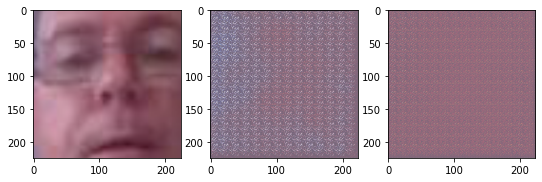

In [ ]:
i = 73


with torch.no_grad():

    try:
      X = torch.load('/content/drive/MyDrive/vgg/vgg_image_features_'+str(i))
    except:
      print('vgg file missing')
      

    f = open('/content/drive/MyDrive/spectrogram/spectrograms_'+str(i)+'.pk','rb')
    spec_dict = pickle.load(f)
    image_path_list = ['/content/drive/MyDrive/reference/'+str(i)+'.jpg' for key in spec_dict] 

    print(i)
    decoder_eval(image_path_list , spec_dict)
    print('****************************************************************')